#  1. Loading the libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime, warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn import metrics, linear_model
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.compose import ColumnTransformer

# 2. Overview of the dataset

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/FaisalSaymeh/Predicting-Flight-Delays/master/flights%20jan.csv')
df

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,2354.0,-11.0,21.0,15.0,205,194.0,169.0,1448,404.0,4.0,430,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,2.0,-8.0,12.0,14.0,280,279.0,263.0,2330,737.0,4.0,750,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,18.0,-2.0,16.0,34.0,286,293.0,266.0,2296,800.0,11.0,806,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,15.0,-5.0,15.0,30.0,285,281.0,258.0,2342,748.0,8.0,805,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,24.0,-1.0,11.0,35.0,235,215.0,199.0,1448,254.0,5.0,320,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469963,2015,1,31,6,B6,839,N658JB,JFK,BQN,2359,2359.0,0.0,18.0,17.0,221,200.0,179.0,1576,416.0,3.0,440,419.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
469964,2015,1,31,6,DL,1887,N855NW,SEA,DTW,2359,2359.0,0.0,16.0,15.0,252,239.0,209.0,1927,644.0,14.0,711,658.0,-13.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
469965,2015,1,31,6,F9,300,N218FR,DEN,TPA,2359,2.0,3.0,35.0,37.0,192,212.0,168.0,1506,525.0,9.0,511,534.0,23.0,0,0,NaN,21.0,0.0,2.0,0.0,0.0
469966,2015,1,31,6,F9,422,N954FR,DEN,ATL,2359,2359.0,0.0,40.0,39.0,162,191.0,141.0,1199,500.0,10.0,441,510.0,29.0,0,0,NaN,29.0,0.0,0.0,0.0,0.0


### These data around 470000 flights have been recorded in January 2015, distributed on 14 airlines and 323 airports in the United States of America.

# 3. Cleaning the data
### Re-organize the columns and deal with the missing data

## 3.1 Reorganize the dataframe

In [ ]:
variables_to_remove = ['TAXI_OUT', 'TAXI_IN', 'WHEELS_ON', 'WHEELS_OFF', 'YEAR', 
                       'MONTH','DAY','DAY_OF_WEEK', 'AIR_SYSTEM_DELAY',
                       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
                       'WEATHER_DELAY', 'DIVERTED', 'CANCELLED', 'CANCELLATION_REASON',
                       'FLIGHT_NUMBER', 'TAIL_NUMBER', 'AIR_TIME']
df.drop(variables_to_remove, axis = 1, inplace = True)
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY',
        'SCHEDULED_TIME', 'ELAPSED_TIME']]
df[:5]

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
0,AS,ANC,SEA,5,2354.0,-11.0,430,408.0,-22.0,205,194.0
1,AA,LAX,PBI,10,2.0,-8.0,750,741.0,-9.0,280,279.0
2,US,SFO,CLT,20,18.0,-2.0,806,811.0,5.0,286,293.0
3,AA,LAX,MIA,20,15.0,-5.0,805,756.0,-9.0,285,281.0
4,AS,SEA,ANC,25,24.0,-1.0,320,259.0,-21.0,235,215.0


## 3.2 Dealing with missing data

In [ ]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['percent of exist data (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('percent of exist data (%)').reset_index(drop = True)

,variable,missing values,percent of exist data (%)
0,ARRIVAL_DELAY,12955,97.243429
1,ELAPSED_TIME,12955,97.243429
2,ARRIVAL_TIME,12271,97.388971
3,DEPARTURE_TIME,11657,97.519618
4,DEPARTURE_DELAY,11657,97.519618
5,AIRLINE,0,100.000000
6,ORIGIN_AIRPORT,0,100.000000
7,DESTINATION_AIRPORT,0,100.000000
8,SCHEDULED_DEPARTURE,0,100.000000
9,SCHEDULED_ARRIVAL,0,100.000000


### Removing the entries that contain missing values because the missing data percentage is very small.

In [ ]:
df.dropna(inplace = True)

In [ ]:
missing_df = df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['percent of exist data (%)']=(df.shape[0]-missing_df['missing values'])/df.shape[0]*100
missing_df.sort_values('percent of exist data (%)').reset_index(drop = True)

,variable,missing values,percent of exist data (%)
0,AIRLINE,0,100.0
1,ORIGIN_AIRPORT,0,100.0
2,DESTINATION_AIRPORT,0,100.0
3,SCHEDULED_DEPARTURE,0,100.0
4,DEPARTURE_TIME,0,100.0
5,DEPARTURE_DELAY,0,100.0
6,SCHEDULED_ARRIVAL,0,100.0
7,ARRIVAL_TIME,0,100.0
8,ARRIVAL_DELAY,0,100.0
9,SCHEDULED_TIME,0,100.0


### Data before removing non values 469968
### Data after removing non values 457013
### Removed data 12955 in percent %02 from the original data

# 4.Comparing Airlines
### We need to compare the airlines' companies to know the max, min, and mean delays in flights by doing basic statistical descriptions of the airlines'.


In [ ]:
airlines_names = pd.read_csv('https://raw.githubusercontent.com/FaisalSaymeh/Predicting-Flight-Delays/master/airlines.csv')
airlines_names

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways
5,OO,Skywest Airlines Inc.
6,AS,Alaska Airlines Inc.
7,NK,Spirit Air Lines
8,WN,Southwest Airlines Co.
9,DL,Delta Air Lines Inc.


In [ ]:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [ ]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}

# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

,min,max,count,mean
AIRLINE,,,,
VX,-20.0,397.0,4647.0,6.896277
HA,-26.0,1003.0,6408.0,1.311954
F9,-32.0,696.0,6735.0,17.910765
NK,-28.0,557.0,8632.0,13.073100
AS,-47.0,444.0,13151.0,3.072086
B6,-27.0,500.0,20482.0,9.988331
MQ,-29.0,780.0,27568.0,15.995865
US,-26.0,638.0,32478.0,5.175011
UA,-40.0,886.0,37363.0,13.885555


In [ ]:
airline = str(input('Enter Ailine IATA Code: '))
df.loc[df['AIRLINE']==airline]

Enter Ailine IATA Code: AA


,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_TIME,ELAPSED_TIME
1,AA,LAX,PBI,10,2.0,-8.0,750,741.0,-9.0,280,279.0
3,AA,LAX,MIA,20,15.0,-5.0,805,756.0,-9.0,285,281.0
8,AA,SFO,DFW,30,19.0,-11.0,545,532.0,-13.0,195,193.0
11,AA,LAS,MIA,35,27.0,-8.0,803,753.0,-10.0,268,266.0
21,AA,SEA,MIA,100,52.0,-8.0,938,939.0,1.0,338,347.0
...,...,...,...,...,...,...,...,...,...,...,...
469939,AA,MIA,MCO,2349,2346.0,-3.0,49,39.0,-10.0,60,53.0
469943,AA,SFO,MIA,2350,2345.0,-5.0,800,753.0,-7.0,310,308.0
469944,AA,SEA,DFW,2350,2350.0,0.0,527,519.0,-8.0,217,209.0
469949,AA,LAX,ORD,2354,2351.0,-3.0,550,553.0,3.0,236,242.0


# 5. Splitting Data and Encoding Categorical Data

In [ ]:
X = df.iloc[:,:-1].values
Y = df.iloc[:,-1].values

### Encoding Independent Variables

In [ ]:
ct = ColumnTransformer(transformers= [('encoder',OneHotEncoder(),[0,1,2])], remainder= 'passthrough')
X = ct.fit_transform(X)
X

<457013x645 sparse matrix of type '<class 'numpy.float64'>'
	with 4535774 stored elements in Compressed Sparse Row format>

### Splitting the data into training and testing datasets

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)

 # 6. Predicting flight delays by Machine Learning Models (Regression)

## 6.1 Linear Regression

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(X_train,Y_train)
prediction1 = lm.predict(X_test)
print("MSE =", metrics.mean_squared_error(Y_test,prediction1))
print("R2 Score =", r2_score(Y_test, prediction1))

MSE = 1.812210640430443e-09
R2 Score = 0.9999999999996676


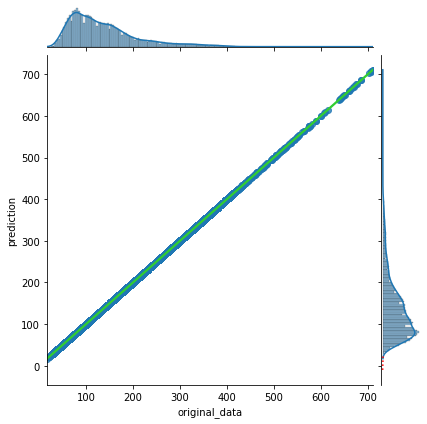

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in prediction1]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

## 6.2  Polynomial

In [ ]:
poly = PolynomialFeatures(degree = 2)
regr = linear_model.LinearRegression()
X_ = poly.fit_transform(X_test)
regr.fit(X_, Y_test)
prediction2 = regr.predict(X_)
print("MSE =", metrics.mean_squared_error(Y_test,prediction2))
print("R2 Score =", r2_score(Y_test, prediction2))

MSE = 2.5429706341927583
R2 Score = 0.9995335553782245


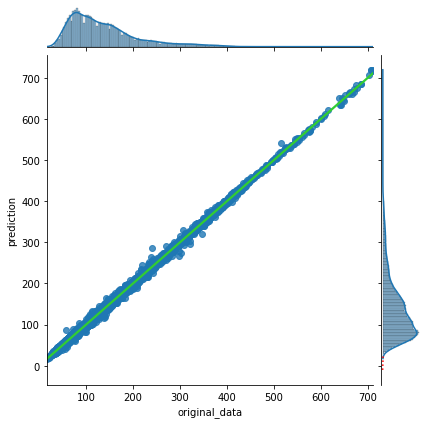

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in prediction2]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

## 6.3 Ridge Regression

In [ ]:
ridgereg = Ridge(alpha=0.3,normalize=True)
poly = PolynomialFeatures(degree = 2)
X_ = poly.fit_transform(X_train)
ridgereg.fit(X_, Y_train)
X_ = poly.fit_transform(X_test)
prediction3 = ridgereg.predict(X_)
print("MSE =", metrics.mean_squared_error(Y_test,prediction3))
print("R2 Score =", r2_score(Y_test, prediction3))

MSE = 73.25872476114971
R2 Score = 0.9865625116926238


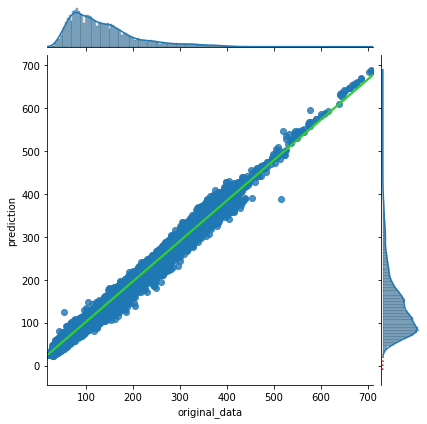

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in prediction3]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

## 6.4 Lasso

In [ ]:
from sklearn.linear_model import Lasso
model = Lasso(alpha=1.0)
model.fit(X_train, Y_train)
prediction4 = model.predict(X_test)
print("MSE =",metrics.mean_squared_error( Y_test,prediction4))
print("R2 Score =", r2_score(Y_test, prediction4))

MSE = 0.024500318578869935
R2 Score = 0.9999955060268179


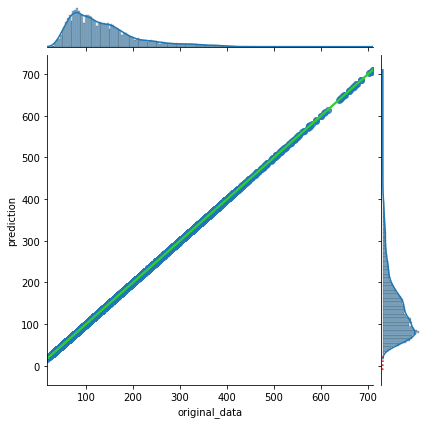

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in prediction4]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

## 6.5 KNN

In [ ]:
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X_train, Y_train)
prediction5 = neigh.predict(X_test)
print("MSE =",metrics.mean_squared_error(Y_test,prediction5))
print("R2 Score =", r2_score(Y_test, prediction5))

MSE = 36.750273513998444
R2 Score = 0.9932590777105758


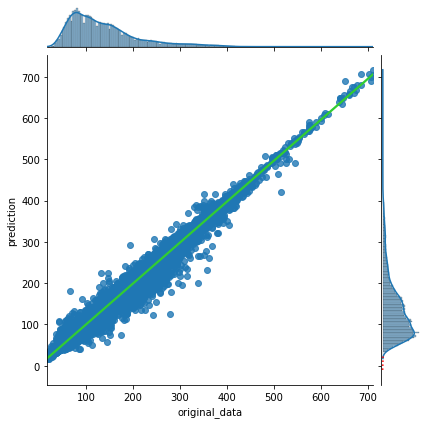

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in prediction5]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

## 6.6 Multiple Linear Regression

In [ ]:
regr = linear_model.LinearRegression()
regr.fit(X_train, Y_train)
prediction6 = regr.predict(X_test)
print("MSE =",metrics.mean_squared_error( Y_test,prediction6))
print("R2 Score =", r2_score(Y_test, prediction6))

MSE = 1.812210640430443e-09
R2 Score = 0.9999999999996676


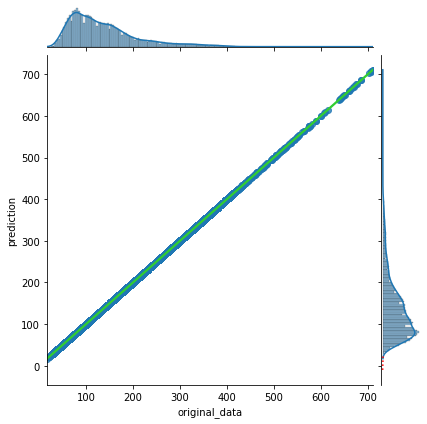

In [ ]:
tips = pd.DataFrame()
tips["prediction"] = pd.Series([float(s) for s in prediction6]) 
tips["original_data"] = pd.Series([float(s) for s in Y_test]) 
sns.jointplot(x="original_data", y="prediction", data=tips, size = 6, ratio = 7,
              joint_kws={'line_kws':{'color':'limegreen'}}, kind='reg')
plt.xlabel('Mean delays (min)', fontsize = 15)
plt.ylabel('Predictions (min)', fontsize = 15)
plt.plot(list(range(-10,25)), list(range(-10,25)), linestyle = ':', color = 'r')

## 6.7 Sorting R2 Score For The Models

In [ ]:
pr1 = r2_score(Y_test, prediction1)
pr2 = r2_score(Y_test, prediction2)
pr3 = r2_score(Y_test, prediction3)
pr4 = r2_score(Y_test, prediction4)
pr5 = r2_score(Y_test, prediction5)
pr6 = r2_score(Y_test, prediction6)

list_of_R2 = {'Linear Regression':pr1, 'Polynomial Regression':pr2, 'Ridge Regression':pr3, 'Lasso':pr4,'KNN':pr5, 'Multiple Linear Regression':pr6}
list_of_R2

{'KNN': 0.9932590777105758,
 'Lasso': 0.9999955060268179,
 'Linear Regression': 0.9999999999996676,
 'Multiple Linear Regression': 0.9999999999996676,
 'Polynomial Regression': 0.9995335553782245,
 'Ridge Regression': 0.9865625116926238}

In [ ]:
data_items = list_of_R2.items()
data_list = list(data_items)
df2 = pd.DataFrame(data_list)
df2.columns = ['Model','R2']
df2.sort_values('R2').reset_index(drop = True)

,Model,R2
0,Ridge Regression,0.986563
1,KNN,0.993259
2,Polynomial Regression,0.999534
3,Lasso,0.999996
4,Linear Regression,1.000000
5,Multiple Linear Regression,1.000000
